[SONAR] Building Deep Sea Sonar animation...
[SONAR] Done!


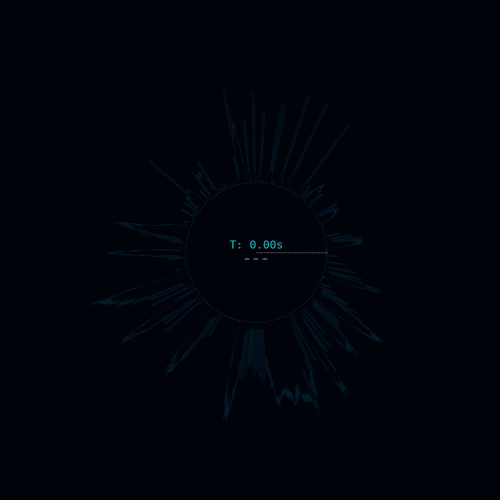

In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import Video, Image, display, HTML
import os
from scipy.interpolate import interp1d
import matplotlib.colors as mcolors

# ── 1. Download Audio ─────────────────────────────────────────────────────────

url = (
    "https://raw.githubusercontent.com/ronniross/biosignal-translator/main/taxonomy/"
    "cellular-life/eukarya/animalia/chordata/vertebrata/mammalia/cetartiodactyla/"
    "odontoceti/physeteridae/physeter/physeter-macrocephalus-sperm-whale/sperm-whale-1.wav"
)
file_name = "sperm-whale-1.wav"
if not os.path.exists(file_name):
    os.system(f"wget -q '{url}' -O {file_name}")

# ── 2. Audio Analysis (Tailored for Clicks) ──────────────────────────────────

y, sr = librosa.load(file_name, sr=None)
duration = librosa.get_duration(y=y, sr=sr)
hop_length = 256 # Higher resolution for fast clicks

# Get Amplitude Envelope (RMS) and normalize
rms = librosa.feature.rms(y=y, hop_length=hop_length)[0]
rms_norm = rms / (np.max(rms) + 1e-9)

# Get Frequencies
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, hop_length=hop_length)
S_db = librosa.power_to_db(S, ref=np.max)
times = librosa.frames_to_time(np.arange(S_db.shape[1]), sr=sr, hop_length=hop_length)
frequencies = librosa.mel_frequencies(n_mels=128, fmin=50.0, fmax=sr / 2)

peak_freq_indices = np.argmax(S_db, axis=0)
peak_freqs = frequencies[peak_freq_indices]

# ── 3. Math for Circular "Radar" Mapping ─────────────────────────────────────

# Time maps to angle (0 to 2*pi)
theta = (times / duration) * 2 * np.pi

# Radius maps to amplitude
base_radius = 2.0
max_spike = 3.0
radius = base_radius + (rms_norm * max_spike)

# Convert Polar to Cartesian
x_data = radius * np.cos(theta)
y_data = radius * np.sin(theta)

# ── 4. Interpolate for Smooth Video ──────────────────────────────────────────

FPS = 30
n_frames = int(duration * FPS)
frame_times = np.linspace(0, duration, n_frames)

def smooth_interp(arr, src_t, dst_t):
    f = interp1d(src_t, arr, kind='linear', bounds_error=False, fill_value=(arr[0], arr[-1]))
    return f(dst_t)

xi = smooth_interp(x_data, times, frame_times)
yi = smooth_interp(y_data, times, frame_times)
ri = smooth_interp(radius, times, frame_times)
ti = smooth_interp(theta, times, frame_times)
fi = smooth_interp(peak_freqs, times, frame_times)
amp_i = smooth_interp(rms_norm, times, frame_times)

# ── 5. Render Echolocation Sonar Theme ───────────────────────────────────────

def render_sonar_theme():
    prefix = 'sonar'
    bg_color = '#02040a' # Deep abyssal blue/black
    print(f"[{prefix.upper()}] Building Deep Sea Sonar animation...")

    fig, ax = plt.subplots(figsize=(10, 10), facecolor=bg_color)
    ax.set_facecolor(bg_color)
    ax.axis('off')

    lim = base_radius + max_spike + 0.5
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)

    # Draw static UI elements
    circle_base = plt.Circle((0, 0), base_radius, color='#004466', fill=False, lw=1, alpha=0.5, ls='--')
    circle_outer = plt.Circle((0, 0), lim-0.2, color='#002233', fill=False, lw=1, alpha=0.3)
    ax.add_patch(circle_base)
    ax.add_patch(circle_outer)

    # Draw the entire audio track faintly in the background
    ax.plot(x_data, y_data, color='#0088aa', lw=0.5, alpha=0.2)

    # Dynamic elements
    TRAIL_LEN = int(FPS * 0.8) # 0.8 second trail
    trail, = ax.plot([], [], color='#00ffff', lw=2.5, alpha=0.9, solid_capstyle='round')
    glow, = ax.plot([], [], color='#00aaff', lw=6, alpha=0.3, solid_capstyle='round')

    playhead_line, = ax.plot([], [], color='#ffffff', lw=1, alpha=0.8, ls=':')
    ping_scatter = ax.scatter([], [], s=[], c=[], cmap='cool', vmin=fi.min(), vmax=fi.max(), zorder=10)

    # Center text
    time_text = ax.text(0, 0.2, "", color='#00ffff', fontsize=16, fontfamily='monospace', ha='center', va='center', alpha=0.8)
    freq_text = ax.text(0, -0.2, "", color='#ffffff', fontsize=22, fontweight='bold', fontfamily='monospace', ha='center', va='center')

    def update(num):
        n = max(num, 1)
        start_idx = max(0, n - TRAIL_LEN)

        # Trail
        trail.set_data(xi[start_idx:n], yi[start_idx:n])
        glow.set_data(xi[start_idx:n], yi[start_idx:n])

        # Playhead (from center to current radius)
        playhead_line.set_data([0, xi[n-1]], [0, yi[n-1]])

        # Ping (Bioluminescent Burst on click)
        current_amp = amp_i[n-1]
        burst_size = (current_amp ** 2) * 2000 + 10 # Exponential burst

        ping_scatter.set_offsets(np.c_[xi[n-1], yi[n-1]])
        ping_scatter.set_sizes([burst_size])
        ping_scatter.set_array(np.array([fi[n-1]]))
        ping_scatter.set_alpha(min(1.0, current_amp * 3 + 0.1))

        # Typography
        time_text.set_text(f"T: {frame_times[n-1]:.2f}s")
        if current_amp > 0.15: # Only show freq if it's a prominent click
            freq_text.set_text(f"{fi[n-1]/1000:.1f} kHz")
            freq_text.set_color(plt.cm.cool((fi[n-1] - fi.min()) / (fi.max() - fi.min())))
        else:
            freq_text.set_text("---")
            freq_text.set_color('#335566')

        return trail, glow, playhead_line, ping_scatter, time_text, freq_text

    # Render Silent Video
    silent_path = f'{prefix}_silent.mp4'
    ani = animation.FuncAnimation(fig, update, frames=n_frames, interval=1000/FPS, blit=True)
    ani.save(silent_path, writer='ffmpeg', fps=FPS, savefig_kwargs={'facecolor': bg_color},
             extra_args=['-vcodec', 'libx264', '-pix_fmt', 'yuv420p', '-crf', '18'])
    plt.close(fig)

    # Mux Audio
    final_mp4 = f'{prefix}_final.mp4'
    os.system(f"ffmpeg -y -i {silent_path} -i {file_name} -c:v copy -c:a aac -b:a 192k -shortest {final_mp4} -loglevel quiet")

    # Render GIF
    final_gif = f'{prefix}_final.gif'
    os.system(f"ffmpeg -y -i {final_mp4} -vf \"fps=15,scale=500:-1:flags=lanczos,split[s0][s1];[s0]palettegen[p];[s1][p]paletteuse\" -loop 0 {final_gif} -loglevel quiet")

    print(f"[{prefix.upper()}] Done!")
    return final_mp4, final_gif

# ── 6. Execute ───────────────────────────────────────────────────────────────

sonar_mp4, sonar_gif = render_sonar_theme()

# ── 7. Display Outputs ───────────────────────────────────────────────────────

display(HTML("""
<div style="background-color:#02040a; padding: 20px; border-radius: 10px; color: #00ffff; font-family: monospace;">
    <h2 style="color: #00aaff;">🌊 Deep-Sea Echolocation Sonar</h2>
    <p>A radial mapping simulating the broadband clicks of the Sperm Whale.
    Time maps to angle, amplitude maps to radius, and frequency dictates the bioluminescent burst color.</p>
</div>
"""))

display(HTML("<h3>High-Res Video with Audio</h3>"))
display(Video(sonar_mp4, embed=True, html_attributes="controls autoplay loop style='border-radius:10px;'"))

display(HTML("<h3>Optimized GIF</h3>"))
display(Image(filename=sonar_gif))

[SONAR] Building Deep Sea Sonar animation...
[SONAR] Done!


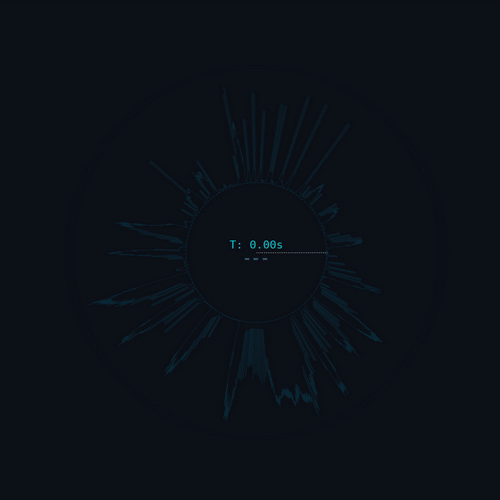

In [2]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import Video, Image, display, HTML
import os
from scipy.interpolate import interp1d
import matplotlib.colors as mcolors

# ── 1. Download Audio ─────────────────────────────────────────────────────────

url = (
    "https://raw.githubusercontent.com/ronniross/biosignal-translator/main/taxonomy/"
    "cellular-life/eukarya/animalia/chordata/vertebrata/mammalia/cetartiodactyla/"
    "odontoceti/physeteridae/physeter/physeter-macrocephalus-sperm-whale/sperm-whale-1.wav"
)
file_name = "sperm-whale-1.wav"
if not os.path.exists(file_name):
    os.system(f"wget -q '{url}' -O {file_name}")

# ── 2. Audio Analysis (Tailored for Clicks) ──────────────────────────────────

y, sr = librosa.load(file_name, sr=None)
duration = librosa.get_duration(y=y, sr=sr)
hop_length = 256 # Higher resolution for fast clicks

# Get Amplitude Envelope (RMS) and normalize
rms = librosa.feature.rms(y=y, hop_length=hop_length)[0]
rms_norm = rms / (np.max(rms) + 1e-9)

# Get Frequencies
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, hop_length=hop_length)
S_db = librosa.power_to_db(S, ref=np.max)
times = librosa.frames_to_time(np.arange(S_db.shape[1]), sr=sr, hop_length=hop_length)
frequencies = librosa.mel_frequencies(n_mels=128, fmin=50.0, fmax=sr / 2)

peak_freq_indices = np.argmax(S_db, axis=0)
peak_freqs = frequencies[peak_freq_indices]

# ── 3. Math for Circular "Radar" Mapping ─────────────────────────────────────

# Time maps to angle (0 to 2*pi)
theta = (times / duration) * 2 * np.pi

# Radius maps to amplitude
base_radius = 2.0
max_spike = 3.0
radius = base_radius + (rms_norm * max_spike)

# Convert Polar to Cartesian
x_data = radius * np.cos(theta)
y_data = radius * np.sin(theta)

# ── 4. Interpolate for Smooth Video ──────────────────────────────────────────

FPS = 30
n_frames = int(duration * FPS)
frame_times = np.linspace(0, duration, n_frames)

def smooth_interp(arr, src_t, dst_t):
    f = interp1d(src_t, arr, kind='linear', bounds_error=False, fill_value=(arr[0], arr[-1]))
    return f(dst_t)

xi = smooth_interp(x_data, times, frame_times)
yi = smooth_interp(y_data, times, frame_times)
ri = smooth_interp(radius, times, frame_times)
ti = smooth_interp(theta, times, frame_times)
fi = smooth_interp(peak_freqs, times, frame_times)
amp_i = smooth_interp(rms_norm, times, frame_times)

# ── 5. Render Echolocation Sonar Theme ───────────────────────────────────────

def render_sonar_theme():
    prefix = 'sonar'
    bg_color = '#0d1117' # Deep abyssal blue/black
    print(f"[{prefix.upper()}] Building Deep Sea Sonar animation...")

    fig, ax = plt.subplots(figsize=(10, 10), facecolor=bg_color)
    ax.set_facecolor(bg_color)
    ax.axis('off')

    lim = base_radius + max_spike + 0.5
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)

    # Draw static UI elements
    circle_base = plt.Circle((0, 0), base_radius, color='#004466', fill=False, lw=1, alpha=0.5, ls='--')
    circle_outer = plt.Circle((0, 0), lim-0.2, color='#002233', fill=False, lw=1, alpha=0.3)
    ax.add_patch(circle_base)
    ax.add_patch(circle_outer)

    # Draw the entire audio track faintly in the background
    ax.plot(x_data, y_data, color='#0088aa', lw=0.5, alpha=0.2)

    # Dynamic elements
    TRAIL_LEN = int(FPS * 0.8) # 0.8 second trail
    trail, = ax.plot([], [], color='#00ffff', lw=2.5, alpha=0.9, solid_capstyle='round')
    glow, = ax.plot([], [], color='#00aaff', lw=6, alpha=0.3, solid_capstyle='round')

    playhead_line, = ax.plot([], [], color='#ffffff', lw=1, alpha=0.8, ls=':')
    ping_scatter = ax.scatter([], [], s=[], c=[], cmap='cool', vmin=fi.min(), vmax=fi.max(), zorder=10)

    # Center text
    time_text = ax.text(0, 0.2, "", color='#00ffff', fontsize=16, fontfamily='monospace', ha='center', va='center', alpha=0.8)
    freq_text = ax.text(0, -0.2, "", color='#ffffff', fontsize=22, fontweight='bold', fontfamily='monospace', ha='center', va='center')

    def update(num):
        n = max(num, 1)
        start_idx = max(0, n - TRAIL_LEN)

        # Trail
        trail.set_data(xi[start_idx:n], yi[start_idx:n])
        glow.set_data(xi[start_idx:n], yi[start_idx:n])

        # Playhead (from center to current radius)
        playhead_line.set_data([0, xi[n-1]], [0, yi[n-1]])

        # Ping (Bioluminescent Burst on click)
        current_amp = amp_i[n-1]
        burst_size = (current_amp ** 2) * 2000 + 10 # Exponential burst

        ping_scatter.set_offsets(np.c_[xi[n-1], yi[n-1]])
        ping_scatter.set_sizes([burst_size])
        ping_scatter.set_array(np.array([fi[n-1]]))
        ping_scatter.set_alpha(min(1.0, current_amp * 3 + 0.1))

        # Typography
        time_text.set_text(f"T: {frame_times[n-1]:.2f}s")
        if current_amp > 0.15: # Only show freq if it's a prominent click
            freq_text.set_text(f"{fi[n-1]/1000:.1f} kHz")
            freq_text.set_color(plt.cm.cool((fi[n-1] - fi.min()) / (fi.max() - fi.min())))
        else:
            freq_text.set_text("---")
            freq_text.set_color('#335566')

        return trail, glow, playhead_line, ping_scatter, time_text, freq_text

    # Render Silent Video
    silent_path = f'{prefix}_silent.mp4'
    ani = animation.FuncAnimation(fig, update, frames=n_frames, interval=1000/FPS, blit=True)
    ani.save(silent_path, writer='ffmpeg', fps=FPS, savefig_kwargs={'facecolor': bg_color},
             extra_args=['-vcodec', 'libx264', '-pix_fmt', 'yuv420p', '-crf', '18'])
    plt.close(fig)

    # Mux Audio
    final_mp4 = f'{prefix}_final.mp4'
    os.system(f"ffmpeg -y -i {silent_path} -i {file_name} -c:v copy -c:a aac -b:a 192k -shortest {final_mp4} -loglevel quiet")

    # Render GIF
    final_gif = f'{prefix}_final.gif'
    os.system(f"ffmpeg -y -i {final_mp4} -vf \"fps=15,scale=500:-1:flags=lanczos,split[s0][s1];[s0]palettegen[p];[s1][p]paletteuse\" -loop 0 {final_gif} -loglevel quiet")

    print(f"[{prefix.upper()}] Done!")
    return final_mp4, final_gif

# ── 6. Execute ───────────────────────────────────────────────────────────────

sonar_mp4, sonar_gif = render_sonar_theme()

# ── 7. Display Outputs ───────────────────────────────────────────────────────

display(HTML("""
<div style="background-color:#0d1117; padding: 20px; border-radius: 10px; color: #00ffff; font-family: monospace;">
    <h2 style="color: #00aaff;"> Deep-Sea Echolocation Sonar</h2>
    <p>A radial mapping simulating the broadband clicks of the Sperm Whale.
    Time maps to angle, amplitude maps to radius, and frequency dictates the bioluminescent burst color.</p>
</div>
"""))

display(HTML("<h3>High-Res Video with Audio</h3>"))
display(Video(sonar_mp4, embed=True, html_attributes="controls autoplay loop style='border-radius:10px;'"))

display(HTML("<h3>Optimized GIF</h3>"))
display(Image(filename=sonar_gif))